In [23]:
# See https://github.com/nsidc/NSIDC-Data-Access-Notebook/tree/master
import requests
import getpass
import socket 
import json
import zipfile
import io
import math
import os
import shutil
import pprint
import re
import time
import matplotlib.pyplot as plt
from requests.auth import HTTPBasicAuth
%matplotlib inline

In [2]:
uid = input('Earthdata Login user name: ') # Enter Earthdata Login user name

Earthdata Login user name:  mikaelk


In [17]:
pswd = getpass.getpass('Earthdata Login password: ') # Enter Earthdata Login password

Earthdata Login password:  ········


In [24]:
pswd

'64523588Bla'

In [4]:
email = input('Email address associated with Earthdata Login account: ') # Enter Earthdata login email 

Email address associated with Earthdata Login account:  m.kaandorp@fz-juelich.de


In [22]:
email

'm.kaandorp@fz-juelich.de'

In [25]:
short_name ='SPL3SMP_E'#'SPL2SMP_E'#'SPL3SMP_E'
params = {
    'short_name': short_name
}

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=params)
results = json.loads(response.content)

# Find all instances of 'version_id' in metadata and print most recent version number

versions = [el['version_id'] for el in results['feed']['entry']]
latest_version = max(versions)
print('The most recent version of ', short_name, ' is ', latest_version)

The most recent version of  SPL3SMP_E  is  005


In [48]:
start_date = '2020-01-01'
start_time = '00:00:00'
end_date = '2021-01-01'
end_time = '00:00:00'
temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'

In [37]:
bounding_box='-50.0,18.0,70.0,75.0'

In [38]:
aoi = '1'

In [49]:
granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'

if aoi == '1':
# bounding box input:
    search_params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'bounding_box': bounding_box
    }
else:
    # If polygon file input:
    search_params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'polygon': polygon,
    }

granules = []
headers={'Accept': 'application/json'}
while True:
    response = requests.get(granule_search_url, params=search_params, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    search_params['page_num'] += 1

print('There are', len(granules), 'granules of', short_name, 'version', latest_version, 'over my area and time of interest.')
granule_sizes = [float(granule['granule_size']) for granule in granules]


There are 367 granules of SPL3SMP_E version 005 over my area and time of interest.


In [50]:
from xml.etree import ElementTree as ET

capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/{short_name}.{latest_version}.xml'

# Create session to store cookie and pass credentials to capabilities url

session = requests.session()
s = session.get(capability_url)
response = session.get(s.url,auth=(uid,pswd))

root = ET.fromstring(response.content)

#collect lists with each service option

subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]
if len(subagent) > 0 :

    # variable subsetting
    variables = [SubsetVariable.attrib for SubsetVariable in root.iter('SubsetVariable')]  
    variables_raw = [variables[i]['value'] for i in range(len(variables))]
    variables_join = [''.join(('/',v)) if v.startswith('/') == False else v for v in variables_raw] 
    variable_vals = [v.replace(':', '/') for v in variables_join]

    # reformatting
    formats = [Format.attrib for Format in root.iter('Format')]
    format_vals = [formats[i]['value'] for i in range(len(formats))]
    format_vals.remove('')

    # reprojection options
    projections = [Projection.attrib for Projection in root.iter('Projection')]

In [51]:
response

<Response [200]>

In [52]:
#print service information depending on service availability and select service options
    
if len(subagent) < 1 :
    print('No services exist for', short_name, 'version', latest_version)
    agent = 'NO'
    bbox = ''
    time_var = ''
    reformat = ''
    projection = ''
    projection_parameters = ''
    coverage = ''
    Boundingshape = ''
else:
    agent = ''
    subdict = subagent[0]
    if subdict['spatialSubsetting'] == 'true' and aoi == '1':
        Boundingshape = ''
        ss = input('Subsetting by bounding box, based on the area of interest inputted above, is available. Would you like to request this service? (y/n)')
        if ss == 'y': bbox = bounding_box
        else: bbox = '' 
    if subdict['spatialSubsettingShapefile'] == 'true' and aoi == '2':
        bbox = ''
        ps = input('Subsetting by geospatial file (Esri Shapefile, KML, etc.) is available. Would you like to request this service? (y/n)')
        if ps == 'y': Boundingshape = geojson
        else: Boundingshape = '' 
    if subdict['temporalSubsetting'] == 'true':
        ts = input('Subsetting by time, based on the temporal range inputted above, is available. Would you like to request this service? (y/n)')
        if ts == 'y': time_var = start_date + 'T' + start_time + ',' + end_date + 'T' + end_time 
        else: time_var = ''
    else: time_var = ''
    if len(format_vals) > 0 :
        print('These reformatting options are available:', format_vals)
        reformat = input('If you would like to reformat, copy and paste the reformatting option you would like (make sure to omit quotes, e.g. GeoTIFF), otherwise leave blank.')
        if reformat == 'n': reformat = '' # Catch user input of 'n' instead of leaving blank
    else: 
        reformat = ''
        projection = ''
        projection_parameters = ''
    if len(projections) > 0:
        valid_proj = [] # select reprojection options based on reformatting selection
        for i in range(len(projections)):
            if 'excludeFormat' in projections[i]:
                exclformats_str = projections[i]['excludeFormat'] 
                exclformats_list = exclformats_str.split(',')
            if ('excludeFormat' not in projections[i] or reformat not in exclformats_list) and projections[i]['value'] != 'NO_CHANGE': valid_proj.append(projections[i]['value'])
        if len(valid_proj) > 0:
            print('These reprojection options are available with your requested format:', valid_proj)
            projection = input('If you would like to reproject, copy and paste the reprojection option you would like (make sure to omit quotes), otherwise leave blank.')
            # Enter required parameters for UTM North and South
            if projection == 'UTM NORTHERN HEMISPHERE' or projection == 'UTM SOUTHERN HEMISPHERE': 
                NZone = input('Please enter a UTM zone (1 to 60 for Northern Hemisphere; -60 to -1 for Southern Hemisphere):')
                projection_parameters = str('NZone:' + NZone)
            else: projection_parameters = ''
        else: 
            print('No reprojection options are supported with your requested format')
            projection = ''
            projection_parameters = ''
    else:
        print('No reprojection options are supported with your requested format')
        projection = ''
        projection_parameters = ''

Subsetting by bounding box, based on the area of interest inputted above, is available. Would you like to request this service? (y/n) y


These reformatting options are available: ['HDF-EOS5', 'NetCDF4-CF', 'ASCII', 'KML', 'GeoTIFF']


If you would like to reformat, copy and paste the reformatting option you would like (make sure to omit quotes, e.g. GeoTIFF), otherwise leave blank. NetCDF4-CF


These reprojection options are available with your requested format: ['GEOGRAPHIC', 'UNIVERSAL TRANSVERSE MERCATOR', 'CYLINDRICAL EQUAL AREA', 'NORTH POLAR STEREOGRAPHIC', 'SOUTH POLAR STEREOGRAPHIC']


If you would like to reproject, copy and paste the reprojection option you would like (make sure to omit quotes), otherwise leave blank. GEOGRAPHIC


In [53]:
# Select variable subsetting

if len(subagent) > 0 :
    if len(variable_vals) > 0:
        v = input('Variable subsetting is available. Would you like to subset a selection of variables? (y/n)')
        if v == 'y':
            print('The', short_name, 'variables to select from include:')
            print(*variable_vals, sep = "\n") 
            coverage = input('If you would like to subset by variable, copy and paste the variables you would like separated by comma (be sure to remove spaces and retain all forward slashes: ')
        else: coverage = ''

#no services selected
if reformat == '' and projection == '' and projection_parameters == '' and coverage == '' and time_var == '' and bbox == '' and Boundingshape == '':
    agent = 'NO'

Variable subsetting is available. Would you like to subset a selection of variables? (y/n) y


The SPL3SMP_E variables to select from include:
/Soil_Moisture_Retrieval_Data_AM
/Soil_Moisture_Retrieval_Data_AM/albedo
/Soil_Moisture_Retrieval_Data_AM/albedo_dca
/Soil_Moisture_Retrieval_Data_AM/albedo_scah
/Soil_Moisture_Retrieval_Data_AM/albedo_scav
/Soil_Moisture_Retrieval_Data_AM/boresight_incidence
/Soil_Moisture_Retrieval_Data_AM/bulk_density
/Soil_Moisture_Retrieval_Data_AM/clay_fraction
/Soil_Moisture_Retrieval_Data_AM/EASE_column_index
/Soil_Moisture_Retrieval_Data_AM/EASE_row_index
/Soil_Moisture_Retrieval_Data_AM/freeze_thaw_fraction
/Soil_Moisture_Retrieval_Data_AM/grid_surface_status
/Soil_Moisture_Retrieval_Data_AM/latitude
/Soil_Moisture_Retrieval_Data_AM/latitude_centroid
/Soil_Moisture_Retrieval_Data_AM/longitude
/Soil_Moisture_Retrieval_Data_AM/longitude_centroid
/Soil_Moisture_Retrieval_Data_AM/radar_water_body_fraction
/Soil_Moisture_Retrieval_Data_AM/retrieval_qual_flag
/Soil_Moisture_Retrieval_Data_AM/retrieval_qual_flag_dca
/Soil_Moisture_Retrieval_Data_AM/ret

If you would like to subset by variable, copy and paste the variables you would like separated by comma (be sure to remove spaces and retain all forward slashes:  


In [54]:
coverage='/Soil_Moisture_Retrieval_Data_AM/EASE_column_index,'\
'/Soil_Moisture_Retrieval_Data_AM/EASE_row_index,'\
'/Soil_Moisture_Retrieval_Data_AM/latitude,'\
'/Soil_Moisture_Retrieval_Data_AM/longitude,'\
'/Soil_Moisture_Retrieval_Data_AM/retrieval_qual_flag,'\
'/Soil_Moisture_Retrieval_Data_AM/soil_moisture,'\
'/Soil_Moisture_Retrieval_Data_AM/soil_moisture_error,'\
'/Soil_Moisture_Retrieval_Data_AM/surface_flag,'\
'/Soil_Moisture_Retrieval_Data_PM/EASE_column_index_pm,'\
'/Soil_Moisture_Retrieval_Data_PM/EASE_row_index_pm,'\
'/Soil_Moisture_Retrieval_Data_PM/latitude_pm,'\
'/Soil_Moisture_Retrieval_Data_PM/longitude_pm,'\
'/Soil_Moisture_Retrieval_Data_PM/retrieval_qual_flag_pm,'\
'/Soil_Moisture_Retrieval_Data_PM/soil_moisture_pm,'\
'/Soil_Moisture_Retrieval_Data_PM/soil_moisture_error_pm,'\
'/Soil_Moisture_Retrieval_Data_PM/surface_flag_pm,'

In [55]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

#Set the request mode to asynchronous if the number of granules is over 100, otherwise synchronous is enabled by default
if len(granules) > 100:
    request_mode = 'async'
    page_size = 2000
else: 
    page_size = 100
    request_mode = 'stream'

#Determine number of orders needed for requests over 2000 granules. 
page_num = math.ceil(len(granules)/page_size)

print('There will be', page_num, 'total order(s) processed for our', short_name, 'request.')

There will be 1 total order(s) processed for our SPL3SMP_E request.


In [56]:
if aoi == '1':
# bounding box search and subset:
    param_dict = {'short_name': short_name, 
                  'version': latest_version, 
                  'temporal': temporal, 
                  'time': time_var, 
                  'bounding_box': bounding_box, 
                  'bbox': bbox, 
                  'format': reformat, 
                  'projection': projection, 
                  'projection_parameters': projection_parameters, 
                  'Coverage': coverage, 
                  'page_size': page_size, 
                  'request_mode': request_mode, 
                  'agent': agent, 
                  'email': email, }
else:
    # If polygon file input:
    param_dict = {'short_name': short_name, 
                  'version': latest_version, 
                  'temporal': temporal, 
                  'time': time_var, 
                  'polygon': polygon,
                  'Boundingshape': Boundingshape, 
                  'format': reformat, 
                  'projection': projection, 
                  'projection_parameters': projection_parameters, 
                  'Coverage': coverage, 
                  'page_size': page_size, 
                  'request_mode': request_mode, 
                  'agent': agent, 
                  'email': email, }

#Remove blank key-value-pairs
param_dict = {k: v for k, v in param_dict.items() if v != ''}

#Convert to string
param_string = '&'.join("{!s}={!r}".format(k,v) for (k,v) in param_dict.items())
param_string = param_string.replace("'","")

#Print API base URL + request parameters
endpoint_list = [] 
for i in range(page_num):
    page_val = i + 1
    API_request = api_request = f'{base_url}?{param_string}&page_num={page_val}'
    endpoint_list.append(API_request)

print(*endpoint_list, sep = "\n") 

https://n5eil02u.ecs.nsidc.org/egi/request?short_name=SPL3SMP_E&version=005&temporal=2020-01-01T00:00:00Z,2021-01-01T00:00:00Z&bounding_box=-50.0,18.0,70.0,75.0&bbox=-50.0,18.0,70.0,75.0&format=NetCDF4-CF&projection=GEOGRAPHIC&Coverage=/Soil_Moisture_Retrieval_Data_AM/EASE_column_index,/Soil_Moisture_Retrieval_Data_AM/EASE_row_index,/Soil_Moisture_Retrieval_Data_AM/latitude,/Soil_Moisture_Retrieval_Data_AM/longitude,/Soil_Moisture_Retrieval_Data_AM/retrieval_qual_flag,/Soil_Moisture_Retrieval_Data_AM/soil_moisture,/Soil_Moisture_Retrieval_Data_AM/soil_moisture_error,/Soil_Moisture_Retrieval_Data_AM/surface_flag,/Soil_Moisture_Retrieval_Data_PM/EASE_column_index_pm,/Soil_Moisture_Retrieval_Data_PM/EASE_row_index_pm,/Soil_Moisture_Retrieval_Data_PM/latitude_pm,/Soil_Moisture_Retrieval_Data_PM/longitude_pm,/Soil_Moisture_Retrieval_Data_PM/retrieval_qual_flag_pm,/Soil_Moisture_Retrieval_Data_PM/soil_moisture_pm,/Soil_Moisture_Retrieval_Data_PM/soil_moisture_error_pm,/Soil_Moisture_Retrieva

In [57]:
# Create an output folder if the folder does not already exist.

path = str(os.getcwd() + '/Outputs')
if not os.path.exists(path):
    os.mkdir(path)

# Different access methods depending on request mode:

if request_mode=='async':
    # Request data service for each page number, and unzip outputs
    for i in range(page_num):
        page_val = i + 1
        print('Order: ', page_val)

    # For all requests other than spatial file upload, use get function
        request = session.get(base_url, params=param_dict)

        print('Request HTTP response: ', request.status_code)

    # Raise bad request: Loop will stop for bad response code.
        request.raise_for_status()
        print('Order request URL: ', request.url)
        esir_root = ET.fromstring(request.content)
        print('Order request response XML content: ', request.content)

    #Look up order ID
        orderlist = []   
        for order in esir_root.findall("./order/"):
            orderlist.append(order.text)
        orderID = orderlist[0]
        print('order ID: ', orderID)

    #Create status URL
        statusURL = base_url + '/' + orderID
        print('status URL: ', statusURL)

    #Find order status
        request_response = session.get(statusURL)    
        print('HTTP response from order response URL: ', request_response.status_code)

    # Raise bad request: Loop will stop for bad response code.
        request_response.raise_for_status()
        request_root = ET.fromstring(request_response.content)
        statuslist = []
        for status in request_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Data request ', page_val, ' is submitting...')
        print('Initial request status is ', status)

    #Continue loop while request is still processing
        while status == 'pending' or status == 'processing': 
            print('Status is not complete. Trying again.')
            time.sleep(10)
            loop_response = session.get(statusURL)

    # Raise bad request: Loop will stop for bad response code.
            loop_response.raise_for_status()
            loop_root = ET.fromstring(loop_response.content)

    #find status
            statuslist = []
            for status in loop_root.findall("./requestStatus/"):
                statuslist.append(status.text)
            status = statuslist[0]
            print('Retry request status is: ', status)
            if status == 'pending' or status == 'processing':
                continue

    #Order can either complete, complete_with_errors, or fail:
    # Provide complete_with_errors error message:
        if status == 'complete_with_errors' or status == 'failed':
            messagelist = []
            for message in loop_root.findall("./processInfo/"):
                messagelist.append(message.text)
            print('error messages:')
            pprint.pprint(messagelist)

    # Download zipped order if status is complete or complete_with_errors
        if status == 'complete' or status == 'complete_with_errors':
            downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
            print('Zip download URL: ', downloadURL)
            print('Beginning download of zipped output...')
            zip_response = session.get(downloadURL)
            # Raise bad request: Loop will stop for bad response code.
            zip_response.raise_for_status()
            with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
                z.extractall(path)
            print('Data request', page_val, 'is complete.')
        else: print('Request failed.')
            
else:
    for i in range(page_num):
        page_val = i + 1
        print('Order: ', page_val)
        print('Requesting...')
        request = session.get(base_url, params=param_dict)
        print('HTTP response from order response URL: ', request.status_code)
        request.raise_for_status()
        d = request.headers['content-disposition']
        fname = re.findall('filename=(.+)', d)
        dirname = os.path.join(path,fname[0].strip('\"'))
        print('Downloading...')
        open(dirname, 'wb').write(request.content)
        print('Data request', page_val, 'is complete.')
    
    # Unzip outputs
    for z in os.listdir(path): 
        if z.endswith('.zip'): 
            zip_name = path + "/" + z 
            zip_ref = zipfile.ZipFile(zip_name) 
            zip_ref.extractall(path) 
            zip_ref.close() 
            os.remove(zip_name) 

Order:  1
Request HTTP response:  201
Order request URL:  https://n5eil02u.ecs.nsidc.org/egi/request?short_name=SPL3SMP_E&version=005&temporal=2020-01-01T00%3A00%3A00Z%2C2021-01-01T00%3A00%3A00Z&bounding_box=-50.0%2C18.0%2C70.0%2C75.0&bbox=-50.0%2C18.0%2C70.0%2C75.0&format=NetCDF4-CF&projection=GEOGRAPHIC&Coverage=%2FSoil_Moisture_Retrieval_Data_AM%2FEASE_column_index%2C%2FSoil_Moisture_Retrieval_Data_AM%2FEASE_row_index%2C%2FSoil_Moisture_Retrieval_Data_AM%2Flatitude%2C%2FSoil_Moisture_Retrieval_Data_AM%2Flongitude%2C%2FSoil_Moisture_Retrieval_Data_AM%2Fretrieval_qual_flag%2C%2FSoil_Moisture_Retrieval_Data_AM%2Fsoil_moisture%2C%2FSoil_Moisture_Retrieval_Data_AM%2Fsoil_moisture_error%2C%2FSoil_Moisture_Retrieval_Data_AM%2Fsurface_flag%2C%2FSoil_Moisture_Retrieval_Data_PM%2FEASE_column_index_pm%2C%2FSoil_Moisture_Retrieval_Data_PM%2FEASE_row_index_pm%2C%2FSoil_Moisture_Retrieval_Data_PM%2Flatitude_pm%2C%2FSoil_Moisture_Retrieval_Data_PM%2Flongitude_pm%2C%2FSoil_Moisture_Retrieval_Data_P

In [58]:

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
    for name in dirs:
        os.rmdir(os.path.join(root, name))    

OSError: [Errno 39] Directory not empty: '/p/project/cjibg36/kaandorp2/Git/TSMP_DA/SMAP/Outputs/240857500'

In [59]:
dirs

['240867051',
 '240865130',
 '240899908',
 '240927569',
 '240865656',
 '240886153',
 '240864029',
 '240876721',
 '240856425',
 '240915752',
 '240859326',
 '240916190',
 '240927595',
 '240887456',
 '241229534',
 '240875416',
 '240881373',
 '240899838',
 '240929941',
 '240900179',
 '240876819',
 '240884962',
 '240922932',
 '240897949',
 '240895419',
 '240912777',
 '240881381',
 '240877857',
 '240886056',
 '240860908',
 '240884585',
 '240902184',
 '240902262',
 '240886729',
 '240886896',
 '240857450',
 '240872473',
 '240886854',
 '240875418',
 '240912665',
 '240887157',
 '240867147',
 '240874247',
 '240885697',
 '240882560',
 '241090751',
 '240919634',
 '241090369',
 '240921315',
 '240895438',
 '240874526',
 '240872577',
 '240896411',
 '240887460',
 '240881507',
 '240886554',
 '240875258',
 '240915336',
 '240886730',
 '240866220',
 '240887141',
 '240929943',
 '240886856',
 '240902258',
 '240886848',
 '240875565',
 '240871399',
 '240883415',
 '240886054',
 '240895429',
 '240855912',
 '2408

In [27]:
import xarray as xr
data = xr.load_dataset('Outputs/SMAP_L3_SM_P_E_20190102_R18290_001_HEGOUT.nc')


In [43]:
pwd

'/p/scratch/cjibg36/kaandorp2/data/SMAP'

In [29]:
import netCDF4
ncf = netCDF4.Dataset('Outputs/SMAP_L3_SM_P_E_20190102_R18290_001_HEGOUT.nc')

In [30]:
ncf

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): <class 'str'> crs()
    groups: Metadata, Soil_Moisture_Retrieval_Data_AM, Soil_Moisture_Retrieval_Data_PM

In [40]:
group_pm = ncf.groups.get('Soil_Moisture_Retrieval_Data_PM')
group_am = ncf.groups.get('Soil_Moisture_Retrieval_Data_AM')

data_pm = xr.open_dataset(xr.backends.NetCDF4DataStore(group_pm))
data_am = xr.open_dataset(xr.backends.NetCDF4DataStore(group_am))

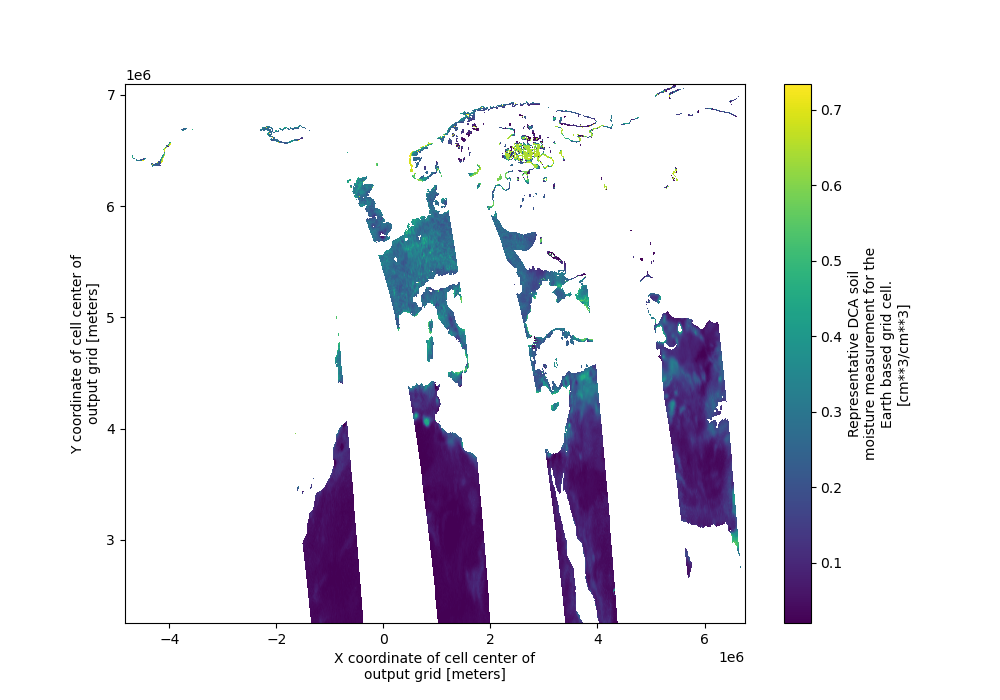

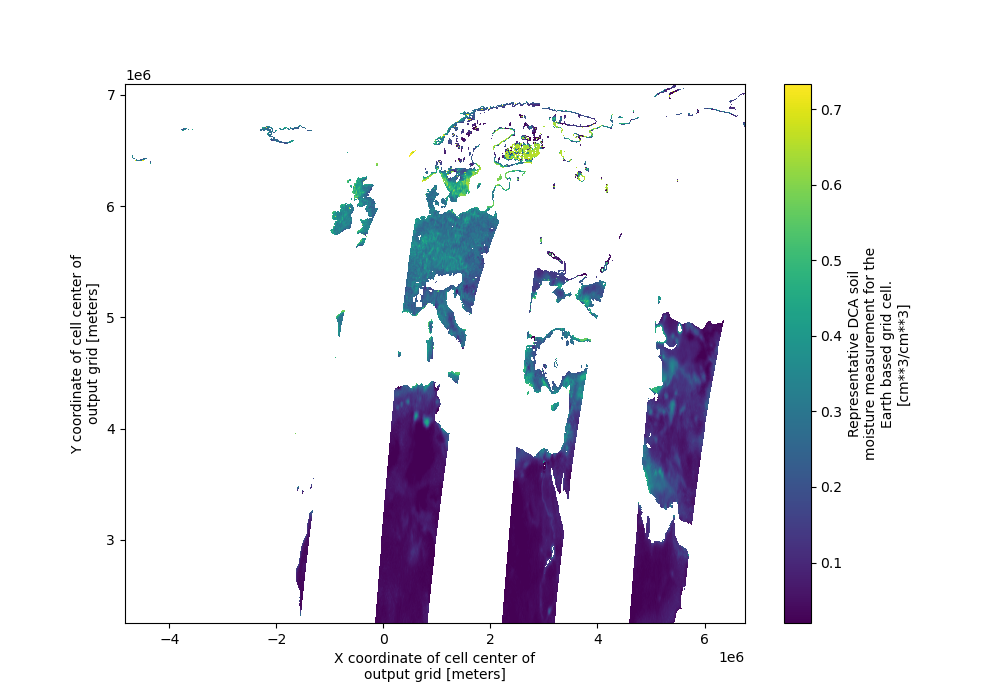

In [41]:
%matplotlib widget
plt.figure(figsize=(10,7))
data_pm.soil_moisture_pm.plot.pcolormesh()

plt.figure(figsize=(10,7))
data_am.soil_moisture.plot.pcolormesh()
